In [1]:
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import sklearn as sk
from sklearn import preprocessing
import seaborn as sns
import matplotlib as plt
from matplotlib.pyplot import figure
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

### First look
#### Given we're working with a larger dataset multiple samples of it need to be collected to gain insight the entries found. Here I'll be jsut looking at the head an tail but more sparse and random sampling techniques can be thought.

#### It's possible to see from the data samples shown below how the "Age" and "Cabin" fields contain Nan entries. It will be necessary to the rid of those later in the data cleaning process.

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [6]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [8]:
print("The percenatge of missing age is: " + str(177/891) + "\n")
print("The percentage of missing cabin is: " + str(687/891)+ "\n")
print("The percentage of missing embarked is: " + str(2/891))

The percenatge of missing age is: 0.19865319865319866

The percentage of missing cabin is: 0.7710437710437711

The percentage of missing embarked is: 0.002244668911335578


#### As shown above many "Age" and even more "Cabin" fields are left empty. Also a couple of "embarked" fields are empty. This has to be taken in consideration when looking into the different measures of those columns.

### Measuring the data

In [9]:
passengers = len(train_data["PassengerId"])


print("The number of passsengers is " + str(passengers) + "\n")
print("The columns found in the dataset are: \n")
print(train_data.columns.values)
print("\n")
print(train_data.describe())

The number of passsengers is 891

The columns found in the dataset are: 

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910

#### Of the total 2221 passengers on the titanic we're considering only 891. The survivor rate is 38%. There is a huge difference in fare paid by the top 1% of the passenegers and the rest of others. The fare does exhibit a very high variance. Also it looks like only a small number of passengers is old, still around 1%.

In [10]:
train_data.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [11]:
print("The percentage of males is: " + str(577/891))

The percentage of males is: 0.6475869809203143


#### By looking at the categorical data it's cler that all names are unique. And how instead there are usually 4 people in the same cabin. Finally also ticket shows quite some duplicates.

# Data Cleaning

#### First I want to get rid of the null values. So every empty age field will be filled with the current median. After that it will be necesary also to drop columns that hold no predictive value such as ticket and cabin.

In [12]:
def fillNan(df):
    df["Age"].fillna(df["Age"].median(), inplace=True)
    df["Fare"].fillna(df["Fare"].median(), inplace=True)
    df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

In [13]:
def categoricalToNumerical(df):
    label = preprocessing.LabelEncoder()
    df["SexCode"] = label.fit_transform(df["Sex"])
    df["EmbarkedCode"] = label.fit_transform(df["Embarked"])
    df["NameCode"] = label.fit_transform(df["Name"])
    df.drop("Sex", axis=1, inplace=True)
    df.drop("Embarked", axis=1, inplace=True)
    df.drop("Name", axis=1, inplace=True)

In [14]:
def dropColumns(df):                               
    drop_column = (["Ticket", "Cabin"])
    df.drop(drop_column, axis=1, inplace=True)

In [15]:
fillNan(train_data)

In [16]:
fillNan(test_data)

In [17]:
dropColumns(train_data)
dropColumns(test_data)

In [18]:
categoricalToNumerical(train_data)
categoricalToNumerical(test_data)

In [19]:
print(train_data.isnull().sum())

PassengerId     0
Survived        0
Pclass          0
Age             0
SibSp           0
Parch           0
Fare            0
SexCode         0
EmbarkedCode    0
NameCode        0
dtype: int64


In [20]:
train_data.pivot_table(columns=['NameCode'], aggfunc='size')

NameCode
0      1
1      1
2      1
3      1
4      1
      ..
886    1
887    1
888    1
889    1
890    1
Length: 891, dtype: int64

#### No double entry in the name column and no null entry in any column. This is the shape of the dataframe now.

In [21]:
train_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,SexCode,EmbarkedCode,NameCode
0,1,0,3,22.0,1,0,7.2500,1,2,108
1,2,1,1,38.0,1,0,71.2833,0,0,190
2,3,1,3,26.0,0,0,7.9250,0,2,353
3,4,1,1,35.0,1,0,53.1000,0,2,272
4,5,0,3,35.0,0,0,8.0500,1,2,15


# Exloratory data analysis

#### First let's visualize the percenatge of survivors

<AxesSubplot:ylabel='Survived'>

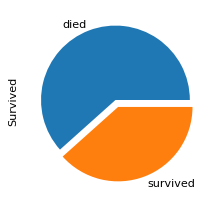

In [22]:
figure(figsize=(3, 6), dpi=80)
train_data['Survived'].replace({0:"died",1:"survived"}).value_counts().plot.pie(explode=[0,0.1])

#### In the next bar plots let's check for the categorical data how each value relates to the survivor.

In [23]:
def bar_plot_survivor_rate(feature):
    figure(figsize=(3, 2))
    sns.barplot(data = train_data, x = feature, y = "Survived").set_title(
                                        f"{feature} on the x axis and Survived on the y axis")
    


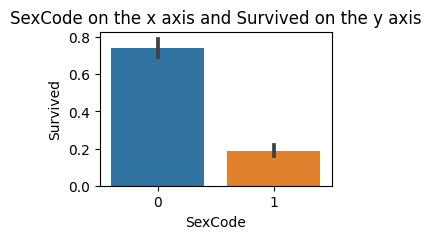

In [24]:
bar_plot_survivor_rate("SexCode")

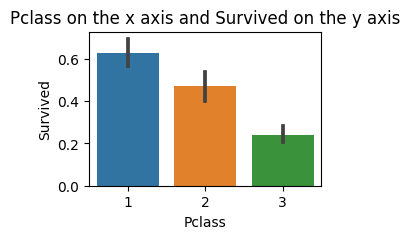

In [25]:
bar_plot_survivor_rate("Pclass")

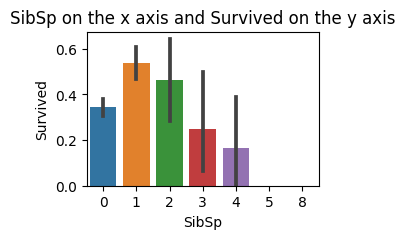

In [26]:
bar_plot_survivor_rate("SibSp")

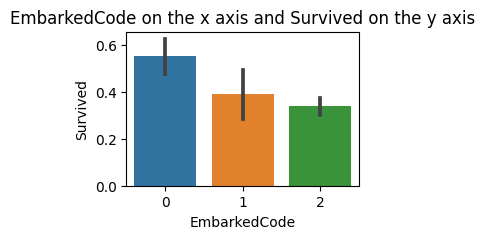

In [27]:
bar_plot_survivor_rate("EmbarkedCode")

#### As it is clearly shown in the above plots, if we were to take a single categorical feature to determine the survivorship of passengers it would be the sex

In [28]:
def tabular_format(feature):
    return train_data[[feature, 'Survived']].groupby([feature],
                                            as_index=False).mean().sort_values(by="Survived")

In [29]:
tabular_format("SexCode")

,SexCode,Survived
1,1,0.188908
0,0,0.742038


In [30]:
tabular_format("Pclass")

,Pclass,Survived
2,3,0.242363
1,2,0.472826
0,1,0.629630


In [31]:
tabular_format("SibSp")

,SibSp,Survived
5,5,0.000000
6,8,0.000000
4,4,0.166667
3,3,0.250000
0,0,0.345395
2,2,0.464286
1,1,0.535885


In [32]:
tabular_format("EmbarkedCode")

,EmbarkedCode,Survived
2,2,0.339009
1,1,0.389610
0,0,0.553571


#### Above are provided some tables to better understand and quantify the plots shown before. But, to further visualize the data also the histograms that relate the age of passengers and their survivor.

In [33]:
def histograms(feature):
    figure(figsize=(4,4))
    sns.histplot(data = train_data , x = feature , hue = "Survived", palette = sns.color_palette(["red" , "blue"]),multiple = "stack" )

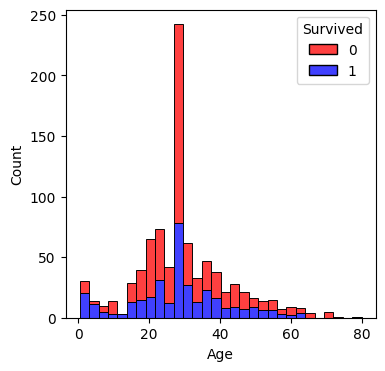

In [34]:
histograms("Age")

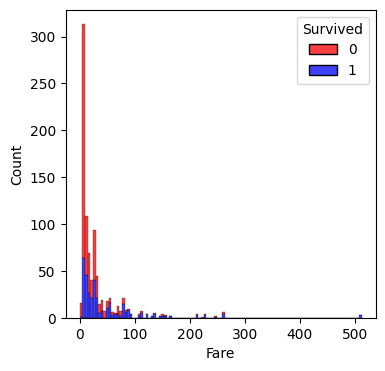

In [35]:
histograms("Fare")

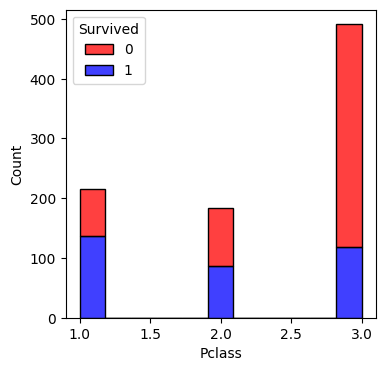

In [36]:
histograms("Pclass")

#### Now judging from this histograms it can be inferred that some correlation exists between the fare paid and the survivorship but more between the passenger class and the survivor of the same passenger. In general it seems that the richer the passenger was the higher the chance of survivor.

# Correlation

#### To put the previous intuition ot the test we can simply compute the correlation bewteen the features, and see how each of those relates to the survivor.

#### This confirms the idea that fare has a meaningful positive correlation to the survivor and that Pclass has an even stronger negative correlation to the survivor. And finally shows how big is teh correlaiton between biological sex and the survivor.

<AxesSubplot:>

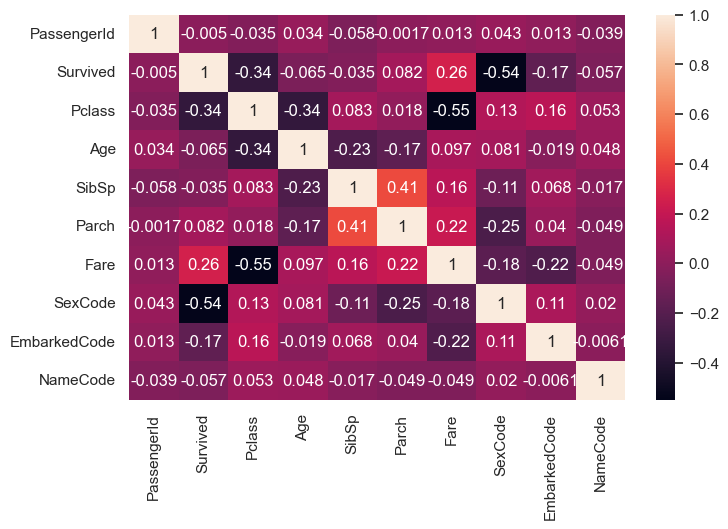

In [37]:
sns.set(rc = {'figure.figsize': (8,5)})
sns.heatmap(train_data.corr(), annot = True, fmt = '.2g')

# Model the data

In [38]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]

X_test = test_data.copy()

#### We're going to try different models and compare the accuracy of each one of them over the test set

In [39]:
log_regression = LogisticRegression()
log_regression.fit(X_train, Y_train)

Y_predict = log_regression.predict(X_test)
acc_log = round(log_regression.score(X_train, Y_train) * 100, 2)

acc_log

C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


79.8

In [40]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

63.52

In [41]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

78.79

In [42]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.35

In [45]:
multi_layer_perceptron = MLPClassifier(random_state=3, max_iter=2000)
multi_layer_perceptron.fit(X_train, Y_train)
Y_pred = multi_layer_perceptron.predict(X_test)
acc_perceptron = round(multi_layer_perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

80.92

In [46]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

100.0

##### The results are clear and it's also clear how decision trees (random forests) are the best technique for the corrrect classification of the data. 

In [51]:
results = pd.DataFrame({'Model': ['Logistic Regression', 'SVM', 'kNN', 'GaussianNB', 'MLBClassifier', 'DecisionTree'],
                       'Score': [acc_log, acc_svc, acc_knn, acc_gaussian, acc_perceptron, acc_decision_tree]}) 

results.sort_values(by='Score', ascending=False)

,Model,Score
5,DecisionTree,100.00
4,MLBClassifier,80.92
0,Logistic Regression,79.80
3,GaussianNB,79.35
2,kNN,78.79
1,SVM,63.52
